In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import argparse
import logging
import sys
import pandas as pd

from scipy import integrate
from src.precession.config import Config
from src.precession.planet import Planet

from src.precession.precession import solve
from sklearn.ensemble import RandomForestRegressor as rf
from scipy import fft


## Three body central force problem Sun-Mercury-Jupiter system

*Note* Assume the Sun is stationary at origin

Terms for Mercury, Jupiter and the Sun have subscripts M, K and S respectively

$$
\mathscr{L} = \frac{1}{2}m_M \dot{r_M}^2 + \frac{1}{2}m_M r_M^2 \dot{\theta_M}^2 + \frac{1}{2}m_J \dot{r_J}^2 + \frac{1}{2}m_J r_J^2 \dot{\theta_J}^2 + \frac{G m_S m_M}{r_M} + \frac{G m_S m_J}{r_J} + \frac{G m_J m_M}{r_{JM}}
$$

where
$$
r_{JM}^2 = r_J^2 + r_M^2 - 2r_Jr_Mcos(\theta_M - \theta_J)
$$



This gives

$$
\frac{\partial \mathscr{L}}{\dot{r_M}} = m_M \dot{r_M}
$$

$$
\frac{\partial \mathscr{L}}{\dot{r_J}} = m_J \dot{r_J}
$$

$$
\frac{\partial \mathscr{L}}{\partial \dot{\theta_M}} = m_M r_M^2 \dot{\theta_M}
$$

$$
\frac{\partial \mathscr{L}}{\partial \dot{\theta_J}} = m_J r_J^2 \dot{\theta_J}
$$

$$
\frac{\partial \mathscr{L}}{\partial r_M} = m_M r_M \dot{\theta_M}^2 - \frac{Gm_Sm_M}{r_M^2} - \frac{Gm_Jm_M}{r_{JM}^2} \frac{\partial r_{JM}}{\partial r_M}
$$

$$
\frac{\partial \mathscr{L}}{\partial r_J} = m_J r_J \dot{\theta_J}^2 - \frac{Gm_Sm_J}{r_J^2} - \frac{Gm_Jm_M}{r_{JM}^2} \frac{\partial r_{JM}}{\partial r_J}
$$

$$
\frac{\partial \mathscr{L}}{\partial \theta_M} = - \frac{Gm_Jm_M}{r_{JM}^2} \frac{\partial r_{JM}}{\partial \theta_M}
$$

$$
\frac{\partial \mathscr{L}}{\partial \theta_J} = - \frac{Gm_Jm_M}{r_{JM}^2} \frac{\partial r_{JM}}{\partial \theta_J}
$$


Where

$$
\frac{\partial r_{JM}}{\partial r_M} = \frac{r_M - r_Jcos(\theta_M - \theta_J)}{r_{JM}}
$$

$$
\frac{\partial r_{JM}}{\partial r_J} = \frac{r_J - r_Mcos(\theta_M - \theta_J)}{r_{JM}}
$$

$$
\frac{\partial r_{JM}}{\partial \theta_M} = - \frac{r_Jr_Msin(\theta_M - \theta_J)}{r_{JM}}
$$

$$
\frac{\partial r_{JM}}{\partial \theta_J} = \frac{r_Jr_Msin(\theta_M - \theta_J)}{r_{JM}}
$$

For $ r_M $

$$
\frac{d}{dt}(\frac{\partial \mathscr{L}}{\partial \dot{r_M}}) = \frac{\partial \mathscr{L}}{\partial r_M}
$$

$$
\ddot{r_M} = r_M \dot{\theta_M}^2 - \frac{Gm_S}{r_M^2} - \frac{Gm_J(r_M - r_Jcos(\theta_M - \theta_J))}{r_{JM}^3}
$$

For $ r_J $

$$
\frac{d}{dt}(\frac{\partial \mathscr{L}}{\partial \dot{r_J}}) = \frac{\partial \mathscr{L}}{\partial r_J}
$$

$$
\ddot{r_J} = r_J \dot{\theta_J}^2 - \frac{Gm_S}{r_J^2} - \frac{Gm_M(r_J - r_Mcos(\theta_M - \theta_J))}{r_{JM}^3}
$$


For $ \theta_M $

$$
\frac{d}{dt}(\frac{\partial \mathscr{L}}{\partial \dot{\theta_M}}) = \frac{\partial \mathscr{L}}{\partial \theta_M}
$$

$$
\frac{d}{dt}(r_M^2 \dot{\theta_M}) = \frac{Gm_Jr_Jr_Msin(\theta_M - \theta_J)}{r_{JM}^3}
$$


For $ \theta_J $

$$
\frac{d}{dt}(\frac{\partial \mathscr{L}}{\partial \dot{\theta_J}}) = \frac{\partial \mathscr{L}}{\partial \theta_J}
$$

$$
\frac{d}{dt}(r_J^2 \dot{\theta_J}) = - \frac{Gm_Mr_Jr_Msin(\theta_M - \theta_J)}{r_{JM}^3}
$$


Separating variables to solve ODEs. 
$$ \dot{r_M} = V_M $$
$$ \dot{r_J} = V_J $$
$$ \dot{\theta_M} = \Omega_M $$
$$ \dot{\theta_J} = \Omega_J $$
$$
\dot{V_M} = r_M \Omega_M^2 - \frac{Gm_S}{r_M^2} - \frac{Gm_J(r_M - r_Jcos(\theta_M - \theta_J))}{(r_J^2 + r_M^2 - 2r_Jr_Mcos(\theta_M - \theta_J))^\frac{3}{2}}
$$
$$
\dot{V_J} = r_J \Omega_J^2 - \frac{Gm_S}{r_J^2} - \frac{Gm_M(r_J - r_Mcos(\theta_M - \theta_J))}{(r_J^2 + r_M^2 - 2r_Jr_Mcos(\theta_M - \theta_J))^\frac{3}{2}}
$$
$$
\dot{\Omega_M} = \frac{Gm_Jr_Jsin(\theta_M - \theta_J)}{r_M(r_J^2 + r_M^2 - 2r_Jr_Mcos(\theta_M - \theta_J))^\frac{3}{2}} - \frac{2V_M\Omega_M}{r_M}
$$
$$
\dot{\Omega_J} = - \frac{Gm_Mr_Msin(\theta_M - \theta_J)}{r_J^2(r_J + r_M^2 - 2r_Jr_Mcos(\theta_M - \theta_J))^\frac{3}{2}} - \frac{2V_J\Omega_J}{r_J}
$$

This system of equations can be solved using appropriate boundary conditions

### Load planet data

In [2]:
config = Config.load("src/precession/config.yml")
planet = Planet.load(config, "src/precession/jupiter.yml")
mercury = Planet.load(config, "src/precession/mercury.yml")

### Use scipy solver to solve the 8 equations

In [3]:
df = solve(config, planet, mercury)

### Finding the period of precession

For precession to occur, the period between r_m maxima will differ from the orbital period. Thus a fourier transform of the r_m should give us this period of r_m maxima. The difference between this period and the period of the orbit should yield the angle of precession.

For this to be computationally possible we will have to compute the DFT of r_m. But we the r_m computed by the solving the 8 equations is not uniformly sampled. We will use sklearn to fit a curve over the values of r_m and then compute r_m at regular samples of time.


Fit a curve

In [4]:
model = rf()
model.fit(df["time"].to_numpy().reshape(-1, 1), df["r_m"].to_numpy())
model_theta = rf()
model_theta.fit(df["time"].to_numpy().reshape(-1, 1), df["theta_m"].to_numpy())

RandomForestRegressor()

### Compute r_m at regular samples of time

In [5]:
t_start = df["time"].iloc[0]
t_end = df["time"].iloc[-1]

t_sample = np.arange(t_start, t_end, (t_end - t_start)/100000)
r_m_fit = model.predict(np.array(t_sample).reshape(-1, 1))
theta_m_fit = model_theta.predict(np.array(t_sample).reshape(-1, 1))

### Sanity check r_m_fit and theta_m_fit

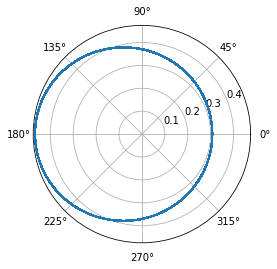

In [6]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(df["theta_m"], df["r_m"])
plt.show()

### Sanity check r_j

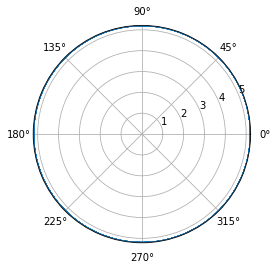

In [7]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(df["theta_p"], df["r_p"])
plt.show()

### Compute fft

In [8]:
frequencies = np.array(fft.rfft(r_m_fit))

### Sanity check the frequencies

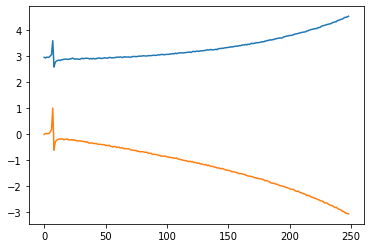

In [9]:
plt.plot(frequencies.real[1:250])
plt.plot(frequencies.imag[1:250])
plt.show()

### Compute the precession angle per year

In [10]:
coeff_max_r = np.argmax(frequencies.real[1:])
total_time = t_sample[-1] - t_sample[0]
# Time period between two maxima of r_m
r_m_period = total_time / (coeff_max_r)
# Difference in angle for an r_m time period
# Pick a time when r_m is max.
max_r_m_index = np.argmax(r_m_fit)

start_time = t_sample[max_r_m_index]
end_time = start_time + r_m_period

[start_theta, end_theta] = model_theta.predict([[start_time], [end_time]])
[r_m_1, r_m_2] = model.predict([[start_time], [end_time]])
print(f"{r_m_1} {r_m_2}")
print(f"{r_m_period} {end_theta - start_theta - 2 * np.pi}")

0.46672126121078883 0.46670216731357206
0.24096144578313253 0.01946519141447567
